### Оцінювання параметрів різницевого рівняння авторегресії із ковзним середнім на основі експериментальних даних за допомогою МНК і РМНК


In [184]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.preprocessing import PolynomialFeatures
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from sklearn.metrics import r2_score
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings

Завантажуємо данні з файлів: Revolns.txt, NONREVNS.txt

In [185]:
rev=np.loadtxt(r"Revolns.txt ")
nonrev=np.loadtxt(r"NONREVNS.txt")

rev_breaker = 480
nonrev_breaker = 780

rev_y_test=rev[rev_breaker:]
rev_train=rev[:rev_breaker]
rev_x_test=np.arange(len(rev_train)+1, len(rev_train)+len(rev_y_test)+1)
nonrev_y_test=nonrev[nonrev_breaker:]
nonrev_train=nonrev[:nonrev_breaker]
nonrev_x_test=np.arange(len(nonrev_train)+1, len(nonrev_train)+len(nonrev_y_test)+1)


In [186]:
rev_train[:500]

array([  1.4,   1.4,   1.4,   1.5,   1.5,   1.6,   1.6,   1.7,   1.8,
         1.9,   1.9,   2.1,   2.3,   2.3,   2.3,   2.5,   2.6,   2.7,
         2.8,   2.9,   3.1,   3.2,   3.3,   3.7,   3.9,   4. ,   4. ,
         4.1,   4.1,   4.2,   4.3,   4.4,   4.6,   4.7,   4.8,   5.1,
         7.5,   7.5,   7.4,   7.5,   7.6,   7.6,   7.8,   7.9,   8.1,
         8.1,   8.1,   8.5,   8.5,   8.3,   8.3,   8.4,   8.5,   8.7,
         8.8,   9.1,   9.3,   9.2,   9.2,   9.7,   9.8,   9.7,   9.6,
         9.7,   9.9,  10.2,  10.4,  10.8,  10.9,  10.9,  11.1,  11.7,
        11.8,  11.6,  11.3,  11.5,  11.8,  12.1,  12.5,  13. ,  13.2,
        13.2,  13.3,  13.7,  13.8,  13.6,  13.2,  13.3,  13.3,  13.4,
        13.7,  14.1,  14.3,  14.3,  14.3,  15. ,  15.1,  14.8,  14.5,
        14.6,  14.7,  14.9,  15.3,  15.7,  16. ,  16.1,  16.2,  17.2,
        32.2,  31.6,  31.4,  31.9,  32.4,  32.9,  33.3,  34. ,  34.6,
        35. ,  36. ,  39.3,  38.8,  38.1,  38. ,  38.4,  39. ,  39.9,
        40.5,  41.6,

In [187]:
len(rev_y_test)

7

Зображаємо дані

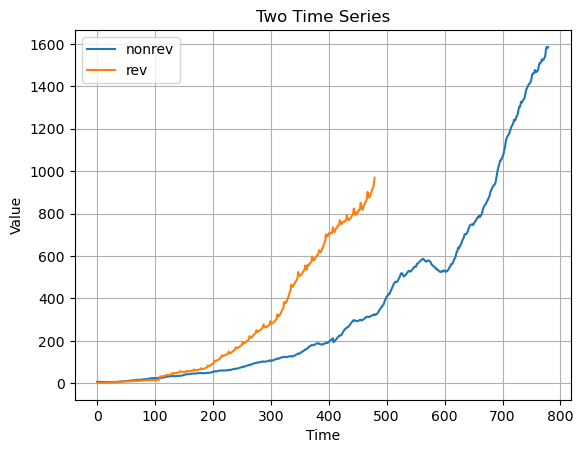

In [188]:
plt.plot(nonrev_train, label='nonrev')
plt.plot(rev_train, label='rev')

plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Two Time Series')
plt.legend()
plt.grid(True)
plt.show()

### Спробуємо лінійний тренд для rev

In [189]:
rev_x_axis_values=np.arange(1, len(rev_train)+1)

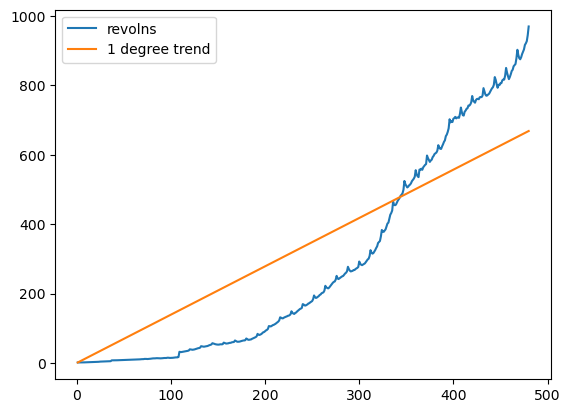

In [190]:
one_degree_model_rev = sm.OLS(rev_train, rev_x_axis_values).fit()
predict_on_one_degree_rev = one_degree_model_rev.predict(rev_x_axis_values) 

plt.plot(rev_x_axis_values,rev_train, label='revolns')
plt.plot(rev_x_axis_values,predict_on_one_degree_rev, label='1 degree trend')
plt.legend()

Отримали модель:

In [191]:
coefficients1_1 = one_degree_model_rev.params
print('y(k)=',coefficients1_1[0], '* k')

y(k)= 1.392301388777716 * k


Спробуємо лінійний тренд для nonrev

In [192]:
nonrev_x_axis_values=np.arange(1, len(nonrev_train)+1)

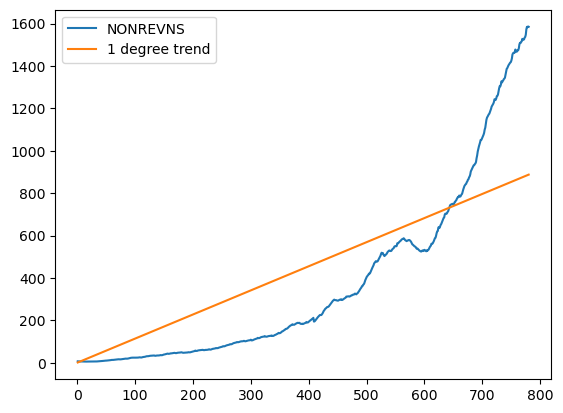

In [193]:
one_degree_model_nonrev = sm.OLS(nonrev_train, nonrev_x_axis_values).fit()
predict_on_one_degree_nonrev = one_degree_model_nonrev.predict(nonrev_x_axis_values) 

plt.plot(nonrev_x_axis_values,nonrev_train, label='NONREVNS')
plt.plot(nonrev_x_axis_values,predict_on_one_degree_nonrev, label='1 degree trend')
plt.legend()

Отримали модель:

In [194]:
coefficients1_2 = one_degree_model_nonrev.params
print('y(k)=',coefficients1_2[0], '* k')

y(k)= 1.1374753611196484 * k


### Спробуємо тренд 2-го порядку:

In [195]:
poly_features = PolynomialFeatures(degree=2)
X_poly = poly_features.fit_transform(rev_x_axis_values[:, np.newaxis])

two_degree_model_rev = sm.OLS(rev_train, X_poly).fit()
predict_on_two_degree_rev = two_degree_model_rev.predict(X_poly)

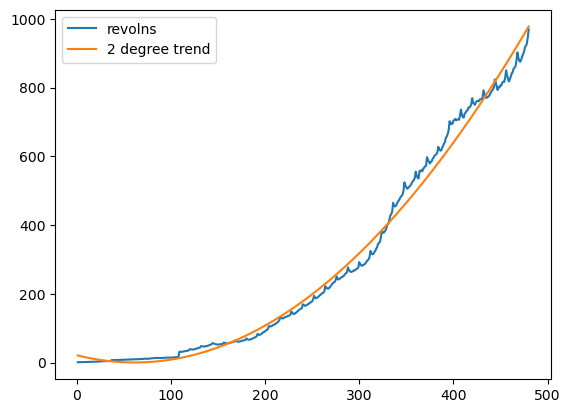

In [196]:
plt.plot(rev_x_axis_values,rev_train, label='revolns')
plt.plot(rev_x_axis_values,predict_on_two_degree_rev, label='2 degree trend')
plt.legend()

Отримали модель:

In [197]:
coefficients2_1 = two_degree_model_rev.params
print('y(k)=',coefficients2_1[0],'+',coefficients2_1[1], '* k +',coefficients2_1[2], '* k^2')

y(k)= 21.53205628007914 + -0.6836592117036349 * k + 0.005574041257283386 * k^2


За графіком можна помітити, що поки що найкращим трендом є тренд 2-го порядку

Спробуємо тренд 2-го порядку для nonrev

In [198]:
poly_features = PolynomialFeatures(degree=2)
X_poly = poly_features.fit_transform(nonrev_x_axis_values[:, np.newaxis])

two_degree_model_nonrev = sm.OLS(nonrev_train, X_poly).fit()
predict_on_two_degree_nonrev = two_degree_model_nonrev.predict(X_poly)

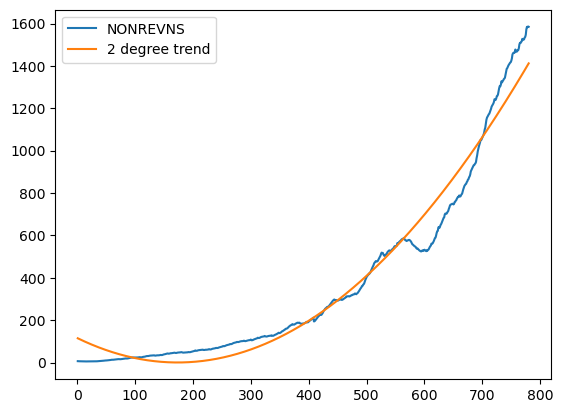

In [199]:
plt.plot(nonrev_x_axis_values,nonrev_train, label='NONREVNS')
plt.plot(nonrev_x_axis_values,predict_on_two_degree_nonrev, label='2 degree trend')
plt.legend()

Отримали модель:

In [200]:
coefficients2_2 = two_degree_model_nonrev.params
print('y(k)=',coefficients2_2[0],'+', coefficients2_2[1], '* k +',coefficients2_2[2], '* k^2')

y(k)= 115.87884861999565 + -1.3313644571789829 * k + 0.0038370951229567893 * k^2


### Спробуємо тренд 3-го порядку:

In [201]:
poly_features = PolynomialFeatures(degree=3)
X_poly = poly_features.fit_transform(rev_x_axis_values[:, np.newaxis])

three_degree_model_rev = sm.OLS(rev_train, X_poly).fit()
predict_on_three_degree_rev = three_degree_model_rev.predict(X_poly)

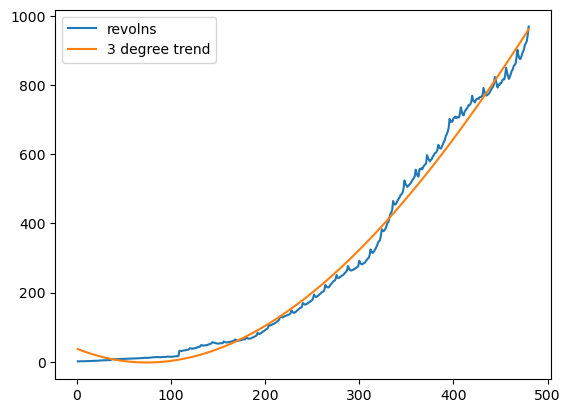

In [202]:
plt.plot(rev_x_axis_values,rev_train, label='revolns')
plt.plot(rev_x_axis_values,predict_on_three_degree_rev, label='3 degree trend')
plt.legend()

In [203]:
coefficients3_1 = three_degree_model_rev.params
print('y(k)=',coefficients3_1[0],'+',coefficients3_1[1], '* k +',coefficients3_1[2], '* k^2 +', coefficients3_1[3], '* k^3' )

y(k)= 38.043825570037185 + -1.093464544649384 * k + 0.00770179174098929 * k^2 + -2.9490651194988046e-06 * k^3


Спробуємо тренд 3-го порядку для nonrev

In [204]:
poly_features = PolynomialFeatures(degree=3)
X_poly = poly_features.fit_transform(nonrev_x_axis_values[:, np.newaxis])

three_degree_model_nonrev = sm.OLS(nonrev_train, X_poly).fit()
predict_on_three_degree_nonrev = three_degree_model_nonrev.predict(X_poly)

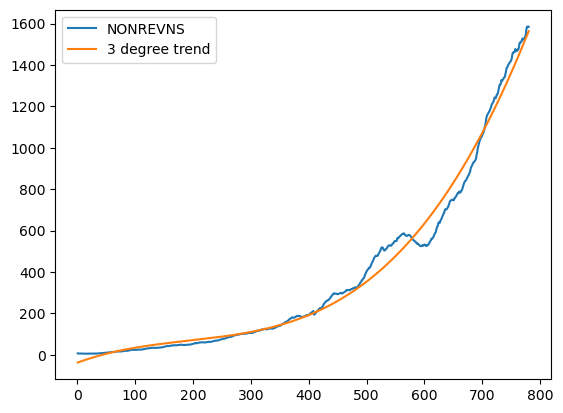

In [205]:
plt.plot(nonrev_x_axis_values,nonrev_train, label='NONREVNS')
plt.plot(nonrev_x_axis_values,predict_on_three_degree_nonrev, label='3 degree trend')
plt.legend()

In [206]:
coefficients3_2 = three_degree_model_nonrev.params
print('y(k)=',coefficients3_2[0],'+', coefficients3_2[1], '* k +',coefficients3_2[2], '* k^2 +',coefficients3_2[3], '* k^3')

y(k)= -38.25919386635472 + 1.029395280974937 * k + -0.003714915270087321 * k^2 + 6.44644506443374e-06 * k^3


### ARIMA

Для першого набору:

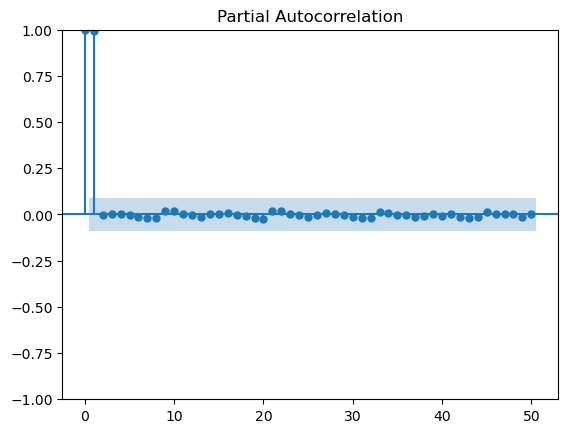

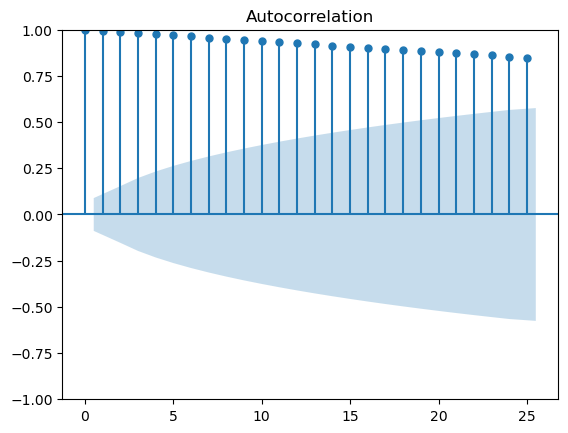

In [207]:
plot_pacf(rev, lags=50)
plot_acf(rev, lags=25)
plt.show()

In [208]:
stepwise_fit = auto_arima(y=rev_train, trace= True, stepwise=True, 
                          max_p=8, max_q=8,
                          start_p=2, start_q=2,
                          method='nm', 
                          suppress_stepwise=True, suppress_warnings=True,
                          seasonal=True, m=12) 
#  start_p=10, start_q=10, max_p=15, max_q=15    |   method='powell', 'bfgs', 'nm'
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(1,0,1)[12]             : AIC=2466.447, Time=0.94 sec
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=3271.804, Time=0.08 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=inf, Time=0.39 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=2732.242, Time=0.56 sec
 ARIMA(2,2,2)(0,0,1)[12]             : AIC=2900.104, Time=0.90 sec
 ARIMA(2,2,2)(1,0,0)[12]             : AIC=2583.076, Time=0.41 sec
 ARIMA(2,2,2)(2,0,1)[12]             : AIC=2518.652, Time=1.17 sec
 ARIMA(2,2,2)(1,0,2)[12]             : AIC=2503.268, Time=2.15 sec
 ARIMA(2,2,2)(0,0,0)[12]             : AIC=3199.810, Time=0.28 sec
 ARIMA(2,2,2)(0,0,2)[12]             : AIC=2828.037, Time=1.92 sec
 ARIMA(2,2,2)(2,0,0)[12]             : AIC=2522.537, Time=0.79 sec
 ARIMA(2,2,2)(2,0,2)[12]             : AIC=3550.760, Time=1.88 sec
 ARIMA(1,2,2)(1,0,1)[12]             : AIC=2284.703, Time=0.90 sec
 ARIMA(1,2,2)(0,0,1)[12]             : AIC=2765.299, Time=0.75 sec
 ARIMA(1,2,2)(1,0,0)[12]

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  480
Model:             SARIMAX(1, 2, 2)x(1, 0, [1], 12)   Log Likelihood               -1136.351
Date:                              Sun, 19 May 2024   AIC                           2284.703
Time:                                      17:56:22   BIC                           2309.721
Sample:                                           0   HQIC                          2294.538
                                              - 480                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6941      0.258     -2.689      0.007      -1.200      -0.188
ma.L1         -0.2275      0.272     -0.836      0.403      -0.761       0.306
ma.L2         -0.5538      0.241     -2.299      0.021      -1.026      -0.082
ar.S.L12       0.9700      0.010     97.421      0.000       0.950       0.990
ma.S.L12      -0.5517      0.036    -15.484      0.000      -0.622      -0.482
sigma2         6.4618      0.186     34.821      0.000       6.098       6.826
===================================================================================
Ljung-Box (L1) (Q):                   1.94   Jarque-Bera (JB):              2733.66
Prob(Q):                              0.16   Prob(JB):                         0.00
Heteroskedasticity (H):               7.02   Skew:                             1.21
Prob(H) (two-sided):                  0.00   Kurtosis:                        14.46
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Оскільки в часовому ряді revolns прослідковується сезонність - зробимо сезонну декомпозицію

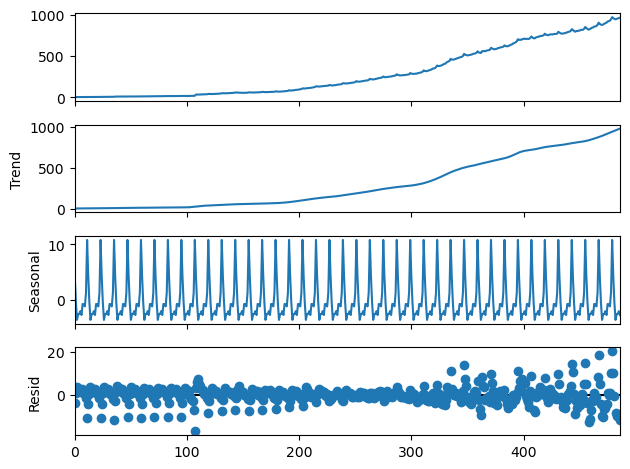

In [209]:
tsdf=pd.DataFrame(rev)
result = seasonal_decompose(tsdf, model='additive',extrapolate_trend='freq', period=12)
result.plot()
plt.show()

In [210]:
warnings.filterwarnings('ignore')
p, d, q = 1, 2, 2
P, D, Q, s = 1, 0, 1, 12
arima_model_rev = ARIMA(rev_train, order=(p, d, q), seasonal_order=(P, D, Q, s), trend='n') # seasonal_order=(P, D, Q, s),
arima_model_rev = arima_model_rev.fit()
predict_on_arima_rev = arima_model_rev.predict(start=1, end=len(rev_train))

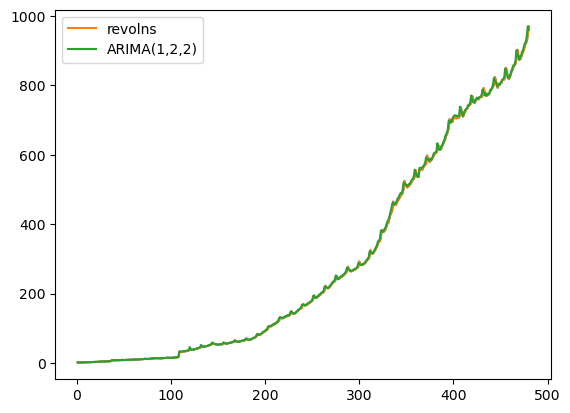

In [211]:
plt.plot(rev_x_axis_values, rev_train)
plt.plot(rev_x_axis_values,rev_train, label='revolns')
plt.plot(rev_x_axis_values, predict_on_arima_rev, label=f'ARIMA({p},{d},{q})')
plt.legend()

Для другого набору:

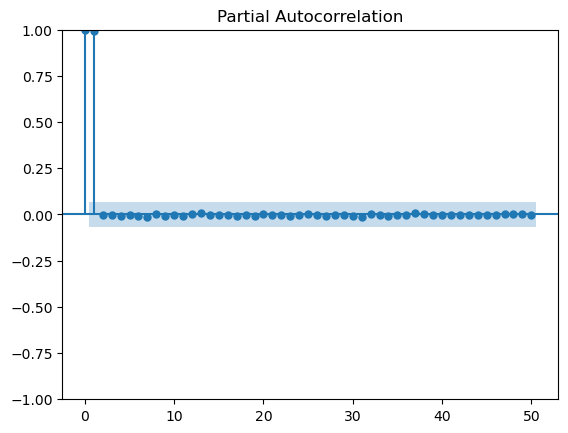

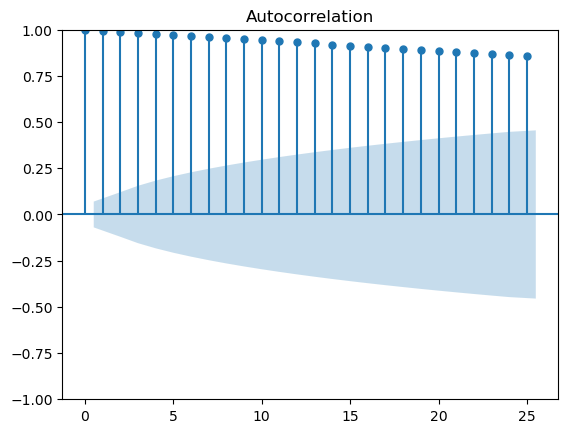

In [212]:
plot_pacf(nonrev, lags=50)
plot_acf(nonrev, lags=25)
plt.show()

In [213]:
stepwise_fit = auto_arima(y=nonrev_train, trace= True, stepwise=True,
                          max_p=8, max_q=8,
                          start_p=2, start_q=2,
                          method='nm',
                          suppress_stepwise=True, suppress_warnings=True,
                          seasonal=True, m=12)
#  start_p=10, start_q=10, max_p=15, max_q=15    |   method='powell', 'bfgs', 'nm'
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(1,0,1)[12]             : AIC=3699.743, Time=0.89 sec
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=4198.966, Time=0.10 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=3909.462, Time=0.56 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=3779.819, Time=0.62 sec
 ARIMA(2,2,2)(0,0,1)[12]             : AIC=3788.256, Time=0.85 sec
 ARIMA(2,2,2)(1,0,0)[12]             : AIC=3741.787, Time=0.52 sec
 ARIMA(2,2,2)(2,0,1)[12]             : AIC=3695.188, Time=1.17 sec
 ARIMA(2,2,2)(2,0,0)[12]             : AIC=3685.297, Time=1.11 sec
 ARIMA(1,2,2)(2,0,0)[12]             : AIC=3709.298, Time=1.14 sec
 ARIMA(2,2,1)(2,0,0)[12]             : AIC=3684.765, Time=1.15 sec
 ARIMA(2,2,1)(1,0,0)[12]             : AIC=3709.192, Time=0.55 sec
 ARIMA(2,2,1)(2,0,1)[12]             : AIC=3677.880, Time=1.14 sec
 ARIMA(2,2,1)(1,0,1)[12]             : AIC=3665.696, Time=0.59 sec
 ARIMA(2,2,1)(0,0,1)[12]             : AIC=3774.150, Time=0.60 sec
 ARIMA(2,2,1)(1,0,2

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                  780
Model:             SARIMAX(1, 2, 1)x(2, 0, [1, 2], 12)   Log Likelihood               -1812.764
Date:                                 Sun, 19 May 2024   AIC                           3639.529
Time:                                         17:57:01   BIC                           3672.126
Sample:                                              0   HQIC                          3652.068
                                                 - 780                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1539      0.023      6.812      0.000       0.110       0.198
ma.L1         -0.8652      0.014    -60.035      0.000      -0.893      -0.837
ar.S.L12       0.5621      0.287      1.960      0.050       0.000       1.124
ar.S.L24       0.2773      0.236      1.177      0.239      -0.184       0.739
ma.S.L12      -0.1240      0.287     -0.432      0.666      -0.687       0.439
ma.S.L24      -0.2272      0.111     -2.045      0.041      -0.445      -0.009
sigma2         5.6784      0.126     44.933      0.000       5.431       5.926
===================================================================================
Ljung-Box (L1) (Q):                   2.31   Jarque-Bera (JB):              2136.26
Prob(Q):                              0.13   Prob(JB):                         0.00
Heteroskedasticity (H):             183.27   Skew:                            -0.03
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.12
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [214]:
p, d, q = 1, 2, 1
P, D, Q, s = 2, 0, 2, 12
arima_model_nonrev = ARIMA(nonrev_train, order=(p, d, q), seasonal_order=(P, D, Q, s), trend='n') # seasonal_order=(P, D, Q, s),
arima_model_nonrev = arima_model_nonrev.fit()
predict_on_arima_nonrev = arima_model_nonrev.predict(start=1, end=len(nonrev_train))

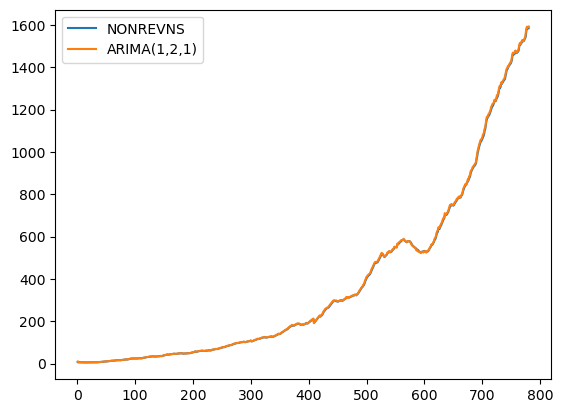

In [215]:
plt.plot(nonrev_x_axis_values, nonrev_train, label='NONREVNS')
plt.plot(nonrev_x_axis_values, predict_on_arima_nonrev, label=f'ARIMA({p},{d},{q})')
plt.legend()

### AR

Для першого набору

In [216]:
ar_model_rev = AutoReg(rev_train, lags=[1, 2], seasonal=True, period=12)
ar_model_rev = ar_model_rev.fit()
print(ar_model_rev.summary())
predict_on_ar_rev = ar_model_rev.predict(start=1, end=len(rev_train))
predict_on_ar_rev[0] = np.mean(predict_on_ar_rev[1:6])

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                  480
Model:               Seas. AutoReg(2)   Log Likelihood               -1331.921
Method:               Conditional MLE   S.D. of innovations              3.926
Date:                Sun, 19 May 2024   AIC                           2693.843
Time:                        17:57:07   BIC                           2756.387
Sample:                             2   HQIC                          2718.432
                                  480                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -6.4183      0.796     -8.063      0.000      -7.978      -4.858
s(2,12)        3.0028      1.136      2.644      0.008       0.777       5.228
s(3,12)        4.4797      1.085      4.129      0.0

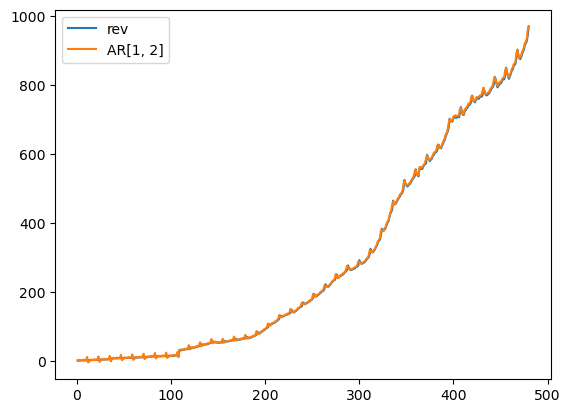

In [217]:
plt.plot(rev_x_axis_values, rev_train, label='rev')
plt.plot(rev_x_axis_values, predict_on_ar_rev, label=f'AR{ar_model_rev.ar_lags}')
plt.legend()

Для другого набору

In [218]:
ar_model_nonrev = AutoReg(nonrev_train, lags=[1, 2], seasonal=False, period=12, trend='ct')
ar_model_nonrev = ar_model_nonrev.fit()
print(ar_model_nonrev.summary())
predict_on_ar_nonrev = ar_model_nonrev.predict(start=1, end=len(nonrev_train))
predict_on_ar_nonrev[0] = np.mean(predict_on_ar_nonrev[1:6])

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                  780
Model:                     AutoReg(2)   Log Likelihood               -1955.231
Method:               Conditional MLE   S.D. of innovations              2.987
Date:                Sun, 19 May 2024   AIC                           3920.462
Time:                        17:57:08   BIC                           3943.746
Sample:                             2   HQIC                          3929.419
                                  780                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0908      0.267     -0.341      0.733      -0.614       0.432
trend          0.0011      0.001      1.082      0.279      -0.001       0.003
y.L1           1.3775      0.033     41.173      0.0

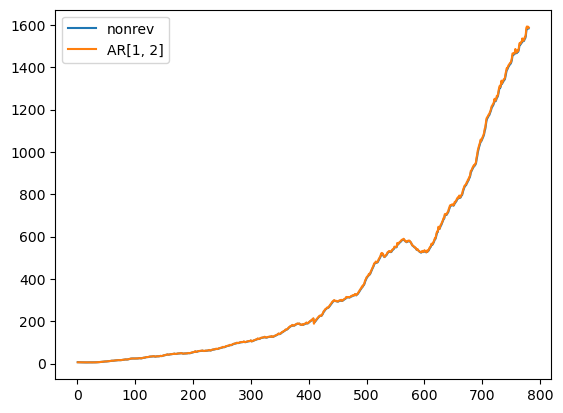

In [219]:
plt.plot(nonrev_x_axis_values, nonrev_train, label='nonrev')
plt.plot(nonrev_x_axis_values, predict_on_ar_nonrev, label=f'AR{ar_model_rev.ar_lags}')
plt.legend()

### ARMA

Для першого набору

In [220]:
p, d, q = 2, 0, 4
P, D, Q, s = 1, 0, 1, 12
arma_model_rev = ARIMA(rev_train, order=(p, d, q), seasonal_order=(P, D, Q, s), trend='n') # seasonal_order=(P, D, Q, s),
arma_model_rev = arma_model_rev.fit()
predict_on_arma_rev = arma_model_rev.predict(start=1, end=len(rev_train))

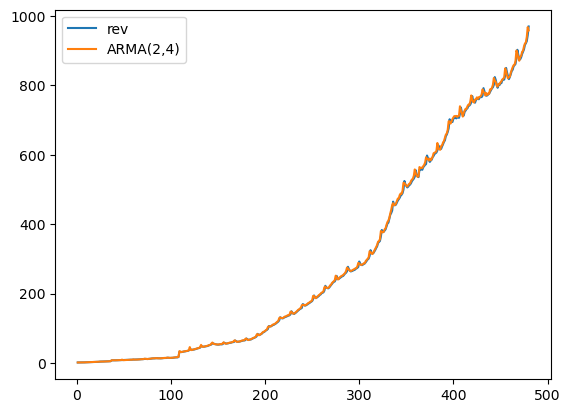

In [221]:
plt.plot(rev_x_axis_values, rev_train, label='rev')
plt.plot(rev_x_axis_values, predict_on_arma_rev, label=f'ARMA({p},{q})')
plt.legend()

Для другого набору

In [222]:
p, d, q = 2, 0, 4
P, D, Q, s = 2, 0, 2, 12
arma_model_nonrev = ARIMA(nonrev_train, order=(p, d, q), seasonal_order=(P, D, Q, s), trend='n') # seasonal_order=(P, D, Q, s),
arma_model_nonrev = arma_model_nonrev.fit()
predict_on_arma_nonrev = arma_model_nonrev.predict(start=1, end=len(nonrev_train))

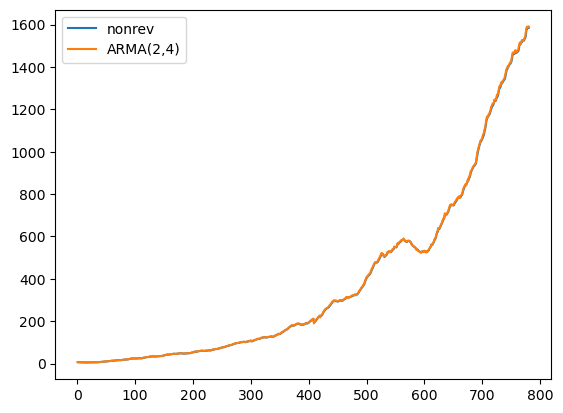

In [223]:
plt.plot(nonrev_x_axis_values, nonrev_train, label='nonrev')
plt.plot(nonrev_x_axis_values, predict_on_arma_nonrev, label=f'ARMA({p},{q})')
plt.legend()

### Статистичні характеристики:

In [224]:
def sqr (y, y_pred):
    return np.sum((y/1000-y_pred/1000)**2)

def mape(y, pred):
    return np.mean(np.abs((y - pred) / y)) * 100

def theil_a(y, pred):
    theil_a_numerator = np.sqrt(np.mean((y - pred) ** 2) / np.mean((y ** 2)))
    theil_a_denominator = np.mean(np.abs((y - pred) / y))
    return theil_a_numerator / theil_a_denominator

Для першого набору:

In [225]:
metrics_for_train_rev = pd.DataFrame({"Model":[],
                            "R^2":[],
                            "SSR":[],
                            "DW":[],
                            })
metrics_for_train_rev.loc[len(metrics_for_train_rev.index)] = ["1 degree trend", r2_score(rev_train, predict_on_one_degree_rev), 
                                                               sqr(rev_train, predict_on_one_degree_rev),durbin_watson(one_degree_model_rev.resid), ]
metrics_for_train_rev.loc[len(metrics_for_train_rev.index)] = ["2 degree trend", r2_score(rev_train, predict_on_two_degree_rev), 
                                                               sqr(rev_train, predict_on_two_degree_rev), durbin_watson(two_degree_model_rev.resid), ]
metrics_for_train_rev.loc[len(metrics_for_train_rev.index)] = ["3 degree trend", r2_score(rev_train, predict_on_three_degree_rev), 
                                                               sqr(rev_train, predict_on_three_degree_rev), durbin_watson(three_degree_model_rev.resid), ]
metrics_for_train_rev.loc[len(metrics_for_train_rev.index)] = ["ARIMA", r2_score(rev_train, predict_on_arima_rev), 
                                                               sqr(rev_train, predict_on_arima_rev), durbin_watson(arima_model_rev.resid), ]
metrics_for_train_rev.loc[len(metrics_for_train_rev.index)] = ["AR", r2_score(rev_train, predict_on_ar_rev), 
                                                               sqr(rev_train, predict_on_ar_rev), durbin_watson(ar_model_rev.resid), ]
metrics_for_train_rev.loc[len(metrics_for_train_rev.index)] = ["ARMA", r2_score(rev_train, predict_on_arma_rev), 
                                                               sqr(rev_train, predict_on_arma_rev), durbin_watson(arma_model_rev.resid), ]

In [226]:
metrics_for_train_rev

,Model,R^2,SSR,DW
0,1 degree trend,0.777639,9.228756,0.001645
1,2 degree trend,0.991920,0.335364,0.041764
2,3 degree trend,0.992359,0.317130,0.044236
3,ARIMA,0.999707,0.012155,1.914806
4,AR,0.999769,0.009587,1.976438
5,ARMA,0.999722,0.011522,1.984435


Для другого набору:

In [227]:
metrics_for_train_nonrev = pd.DataFrame({"Model":[],
                            "R^2":[],
                            "SSR":[],
                            "DW":[], })

metrics_for_train_nonrev.loc[len(metrics_for_train_nonrev.index)] = ["1 degree trend", r2_score(nonrev_train, predict_on_one_degree_nonrev), 
                                                                     sqr(nonrev_train, predict_on_one_degree_nonrev), durbin_watson(one_degree_model_nonrev.resid), ]
metrics_for_train_nonrev.loc[len(metrics_for_train_nonrev.index)] = ["2 degree trend", r2_score(nonrev_train, predict_on_two_degree_nonrev), 
                                                                     sqr(nonrev_train, predict_on_two_degree_nonrev), durbin_watson(two_degree_model_nonrev.resid), ]
metrics_for_train_nonrev.loc[len(metrics_for_train_nonrev.index)] = ["3 degree trend", r2_score(nonrev_train, predict_on_three_degree_nonrev), 
                                                                     sqr(nonrev_train, predict_on_three_degree_nonrev), durbin_watson(three_degree_model_nonrev.resid)]
metrics_for_train_nonrev.loc[len(metrics_for_train_nonrev.index)] = ["ARIMA", r2_score(nonrev_train, predict_on_arima_nonrev), 
                                                                     sqr(nonrev_train,predict_on_arima_nonrev),    durbin_watson(arima_model_nonrev.resid)]
metrics_for_train_nonrev.loc[len(metrics_for_train_nonrev.index)] = ["AR", r2_score(nonrev_train, predict_on_ar_nonrev), sqr(nonrev_train, predict_on_ar_nonrev),
                                                                     durbin_watson(ar_model_nonrev.resid), ]
metrics_for_train_nonrev.loc[len(metrics_for_train_nonrev.index)] = ["ARMA", r2_score(nonrev_train, predict_on_arma_nonrev), sqr(nonrev_train, predict_on_arma_nonrev),
                                                                     durbin_watson(arma_model_nonrev.resid), ]

In [228]:
metrics_for_train_nonrev

,Model,R^2,SSR,DW
0,1 degree trend,0.690821,42.516258,0.000279
1,2 degree trend,0.969356,4.214015,0.002051
2,3 degree trend,0.988313,1.607053,0.005001
3,ARIMA,0.999922,0.010659,1.986718
4,AR,0.999945,0.007525,2.052237
5,ARMA,0.999940,0.008231,1.914139


### Таблиця результатів статичного прогнозування на 7 кроків вперед для rev набору

In [229]:
# Для тренду 3-го порядку
X_poly = poly_features.fit_transform(rev_x_test[:, np.newaxis])
test_predict_on_three_degree_rev = three_degree_model_rev.predict(X_poly)

# Для ARIMA
test_predict_on_arima_rev = arima_model_rev.predict(start=len(rev_train)+1, end=len(rev_train)+len(rev_y_test))

# Для AR
test_predict_on_ar_rev = ar_model_rev.predict(start=len(rev_train)+1, end=len(rev_train)+len(rev_y_test))

# Для ARMA
test_predict_on_arma_rev = arma_model_rev.predict(start=len(rev_train)+1, end=len(rev_train)+len(rev_y_test))

Обчислимо статистики(MSE, MAE, MAPE, Theil-a):

In [230]:
metrics_for_static_predict_rev = pd.DataFrame({"Model":[],
                                               "MSE":[],
                                               "MAE":[],
                                               "MAPE":[],
                                               "Theil-a":[]})
metrics_for_static_predict_rev.loc[len(metrics_for_static_predict_rev.index)] = ["3 degree trend", mean_squared_error(rev_y_test, test_predict_on_three_degree_rev),
                                                                                 mean_absolute_error(rev_y_test, test_predict_on_three_degree_rev),
                                                                                 mape(rev_y_test, test_predict_on_three_degree_rev),
                                                                                 theil_a(rev_y_test, test_predict_on_three_degree_rev), ]
metrics_for_static_predict_rev.loc[len(metrics_for_static_predict_rev.index)] = ["ARIMA", mean_squared_error(rev_y_test, test_predict_on_arima_rev),
                                                                                 mean_absolute_error(rev_y_test, test_predict_on_arima_rev),
                                                                                 mape(rev_y_test, test_predict_on_arima_rev),
                                                                                 theil_a(rev_y_test, test_predict_on_arima_rev), ]
metrics_for_static_predict_rev.loc[len(metrics_for_static_predict_rev.index)] = ["AR", mean_squared_error(rev_y_test, test_predict_on_ar_rev),
                                                                                 mean_absolute_error(rev_y_test, test_predict_on_ar_rev),
                                                                                 mape(rev_y_test, test_predict_on_ar_rev),
                                                                                 theil_a(rev_y_test, test_predict_on_ar_rev), ]
metrics_for_static_predict_rev.loc[len(metrics_for_static_predict_rev.index)] = ["ARMA", mean_squared_error(rev_y_test, test_predict_on_arma_rev),
                                                                                 mean_absolute_error(rev_y_test, test_predict_on_arma_rev),
                                                                                 mape(rev_y_test, test_predict_on_arma_rev),
                                                                                 theil_a(rev_y_test, test_predict_on_arma_rev), ]

In [231]:
metrics_for_static_predict_rev

,Model,MSE,MAE,MAPE,Theil-a
0,3 degree trend,681.659255,24.989728,2.622016,1.044109
1,ARIMA,499.125104,19.341108,2.024918,1.156897
2,AR,952.571205,29.705561,3.115486,1.038772
3,ARMA,62.052398,7.575247,0.793424,1.041050


#### Графік прогнозованих значень:

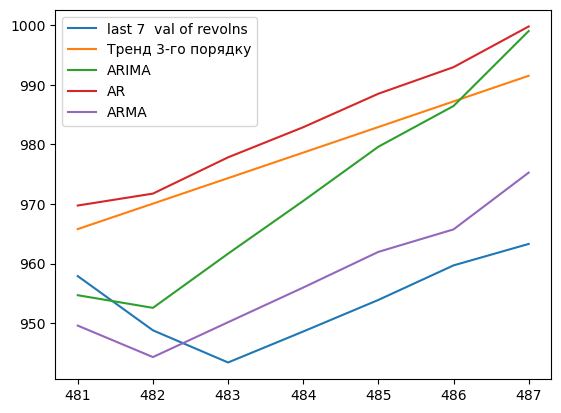

In [232]:
plt.plot(rev_x_test, rev_y_test, label='last 7  val of revolns')
# plt.plot(rev_x_axis_values,rev_train, label='revolns')
plt.plot(rev_x_test, test_predict_on_three_degree_rev, label='Тренд 3-го порядку')
plt.plot(rev_x_test, test_predict_on_arima_rev, label='ARIMA')
plt.plot(rev_x_test, test_predict_on_ar_rev, label='AR')
plt.plot(rev_x_test, test_predict_on_arma_rev, label='ARMA')
plt.legend()

### Таблиця результатів статичного прогнозування на 7 кроків вперед для nonrev набору

In [233]:
# Для тренду 3-го порядку
X_poly = poly_features.fit_transform(nonrev_x_test[:, np.newaxis])
test_predict_on_three_degree_nonrev = three_degree_model_nonrev.predict(X_poly)

# Для ARIMA
test_predict_on_arima_nonrev = arima_model_nonrev.predict(start=len(nonrev_train)+1, end=len(nonrev_train)+len(nonrev_y_test))

# Для AR
test_predict_on_ar_nonrev = ar_model_nonrev.predict(start=len(nonrev_train)+1, end=len(nonrev_train)+len(nonrev_y_test))

# Для ARMA
test_predict_on_arma_nonrev = arma_model_nonrev.predict(start=len(nonrev_train)+1, end=len(nonrev_train)+len(nonrev_y_test))

Обчислимо статистики(MSE, MAE, MAPE, Theil-a):

In [234]:
metrics_for_static_predict_nonrev = pd.DataFrame({"Model":[],
                                               "MSE":[],
                                               "MAE":[],
                                               "MAPE":[],
                                               "Theil-a":[]})
metrics_for_static_predict_nonrev.loc[len(metrics_for_static_predict_nonrev.index)] = ["3 degree trend", 
                                                                                       mean_squared_error(nonrev_y_test, test_predict_on_three_degree_nonrev),
                                                                                 mean_absolute_error(nonrev_y_test, test_predict_on_three_degree_nonrev),
                                                                                 mape(nonrev_y_test, test_predict_on_three_degree_nonrev),
                                                                                 theil_a(nonrev_y_test, test_predict_on_three_degree_nonrev), ]
metrics_for_static_predict_nonrev.loc[len(metrics_for_static_predict_nonrev.index)] = ["ARIMA", 
                                                                                       mean_squared_error(nonrev_y_test, test_predict_on_arima_nonrev),
                                                                                 mean_absolute_error(nonrev_y_test, test_predict_on_arima_nonrev),
                                                                                 mape(nonrev_y_test, test_predict_on_arima_nonrev),
                                                                                 theil_a(nonrev_y_test, test_predict_on_arima_nonrev), ]
metrics_for_static_predict_nonrev.loc[len(metrics_for_static_predict_nonrev.index)] = ["AR", 
                                                                                       mean_squared_error(nonrev_y_test, test_predict_on_ar_nonrev),
                                                                                 mean_absolute_error(nonrev_y_test, test_predict_on_ar_nonrev),
                                                                                 mape(nonrev_y_test, test_predict_on_ar_nonrev),
                                                                                 theil_a(nonrev_y_test, test_predict_on_ar_nonrev), ]
metrics_for_static_predict_nonrev.loc[len(metrics_for_static_predict_nonrev.index)] = ["ARMA", 
                                                                                       mean_squared_error(nonrev_y_test, test_predict_on_arma_nonrev),
                                                                                 mean_absolute_error(nonrev_y_test, test_predict_on_arma_nonrev),
                                                                                 mape(nonrev_y_test, test_predict_on_arma_nonrev),
                                                                                 theil_a(nonrev_y_test, test_predict_on_arma_nonrev), ]

In [235]:
metrics_for_static_predict_nonrev

,Model,MSE,MAE,MAPE,Theil-a
0,3 degree trend,132.303673,8.325524,0.521681,1.379160
1,ARIMA,67.162773,5.970457,0.372418,1.376472
2,AR,434.161074,18.716836,1.169180,1.114750
3,ARMA,67.492576,5.055404,0.315063,1.631038


#### Графік прогнозованих значень:

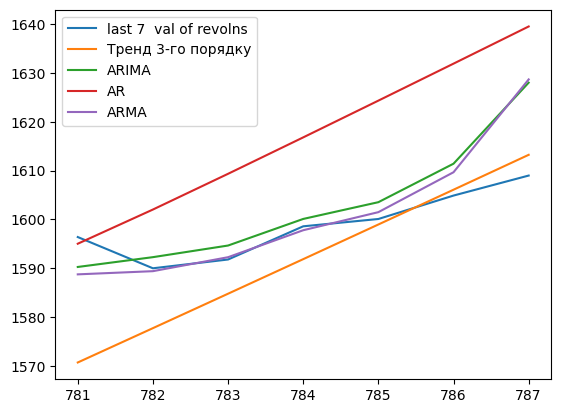

In [236]:
plt.plot(nonrev_x_test, nonrev_y_test, label='last 7  val of revolns')
# plt.plot(nonrev_x_axis_values,nonrev_train, label='nonrevolns')
plt.plot(nonrev_x_test, test_predict_on_three_degree_nonrev, label='Тренд 3-го порядку')
plt.plot(nonrev_x_test, test_predict_on_arima_nonrev, label='ARIMA')
plt.plot(nonrev_x_test, test_predict_on_ar_nonrev, label='AR')
plt.plot(nonrev_x_test, test_predict_on_arma_nonrev, label='ARMA')
plt.legend()

Реалізуємо функції динамічного прогнозування

In [237]:
def dynamic_arima(timeseries, prediction_steps, order, seasonal_order, trend):  
    timeseries_lenth = len(timeseries)
    prediction = []
    
    for step in range(prediction_steps):
        model = ARIMA(timeseries[:timeseries_lenth-7+step], order=order, seasonal_order=seasonal_order, trend=trend)
        model = model.fit()
        temp_predict = model.predict(start=timeseries_lenth-6+step, end=timeseries_lenth-6+step)
        prediction.append(temp_predict)
    return prediction

def dynamic_ar(timeseries, prediction_steps, lags, seasonal, period): 
    timeseries_lenth = len(timeseries)
    prediction = []
    
    for step in range(prediction_steps):
        model = AutoReg(timeseries[:timeseries_lenth-7+step], lags=lags, seasonal=seasonal, period=period)
        model = model.fit()
        temp_predict = model.predict(start=timeseries_lenth-6+step, end=timeseries_lenth-6+step)
        prediction.append(temp_predict)
    return prediction

### Таблиця результатів динамічного прогнозування на 7 кроків вперед для rev набору

In [238]:
# Для ARIMA
dynamic_arima_rev_prediction = dynamic_arima(rev, 7, order=(1, 2, 2), seasonal_order=(1, 0, 1, 12), trend= 'n')

# Для AR
dynamic_ar_rev_prediction =  dynamic_ar(rev, 7, lags=[1, 2], seasonal=True, period=12)

# Для ARMA
dynamic_arma_rev_prediction = dynamic_arima(rev, 7, order=(2, 0, 4), seasonal_order=(2, 0, 2, 12), trend= 'n')

In [239]:
dynamic_arma_rev_prediction

[array([950.04952623]),
 array([943.90957644]),
 array([948.78282788]),
 array([954.68494565]),
 array([960.04229072]),
 array([963.19608591]),
 array([972.56851061])]

Обчислимо статистики(MSE, MAE, MAPE, Theil-a):

In [240]:
metrics_for_dynamic_predict_rev = pd.DataFrame({"Model":[],
                                               "MSE":[],
                                               "MAE":[],
                                               "MAPE":[],
                                               "Theil-a":[]})
metrics_for_dynamic_predict_rev.loc[len(metrics_for_dynamic_predict_rev.index)] = ["ARIMA", mean_squared_error(rev_y_test, dynamic_arima_rev_prediction),
                                                                                 mean_absolute_error(rev_y_test, dynamic_arima_rev_prediction),
                                                                                 mape(rev_y_test, dynamic_arima_rev_prediction),
                                                                                 theil_a(rev_y_test, dynamic_arima_rev_prediction), ]
metrics_for_dynamic_predict_rev.loc[len(metrics_for_dynamic_predict_rev.index)] = ["AR", mean_squared_error(rev_y_test, dynamic_ar_rev_prediction),
                                                                                 mean_absolute_error(rev_y_test, dynamic_ar_rev_prediction),
                                                                                 mape(rev_y_test, dynamic_ar_rev_prediction),
                                                                                 theil_a(rev_y_test, dynamic_ar_rev_prediction), ]
metrics_for_dynamic_predict_rev.loc[len(metrics_for_dynamic_predict_rev.index)] = ["ARMA", mean_squared_error(rev_y_test, dynamic_arma_rev_prediction),
                                                                                 mean_absolute_error(rev_y_test, dynamic_arma_rev_prediction),
                                                                                 mape(rev_y_test, dynamic_arma_rev_prediction),
                                                                                 theil_a(rev_y_test, dynamic_arma_rev_prediction), ]

In [241]:
metrics_for_dynamic_predict_rev

,Model,MSE,MAE,MAPE,Theil-a
0,ARIMA,77.643993,7.786855,1.051646,1.253554
1,AR,69.611078,7.613123,1.011565,1.227079
2,ARMA,41.057603,6.159365,0.963459,1.250530


### Графік прогнозованих значень:

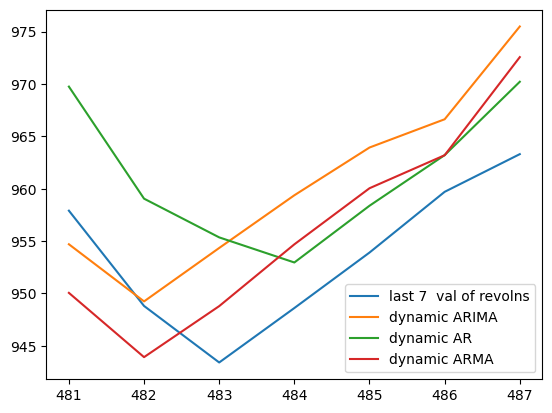

In [242]:
plt.plot(rev_x_test, rev_y_test, label='last 7  val of revolns')
# plt.plot(rev_x_axis_values[450:],rev_train[450:], label='revolns[450:]')
plt.plot(rev_x_test, dynamic_arima_rev_prediction, label='dynamic ARIMA')
plt.plot(rev_x_test, dynamic_ar_rev_prediction, label='dynamic AR')
plt.plot(rev_x_test, dynamic_arma_rev_prediction, label='dynamic ARMA')
plt.legend()

### Таблиця результатів динамічного прогнозування на 7 кроків вперед для rev набору

In [243]:
# Для ARIMA
dynamic_arima_nonrev_prediction = dynamic_arima(nonrev, 7, order=(1, 2, 2), seasonal_order=(1, 0, 1, 12), trend= 'n')

# Для AR
dynamic_ar_nonrev_prediction =  dynamic_ar(nonrev, 7, lags=[1, 2], seasonal=True, period=12)

# Для ARMA
dynamic_arma_nonrev_prediction = dynamic_arima(nonrev, 7, order=(2, 0, 4), seasonal_order=(2, 0, 2, 12), trend= 'n')

In [244]:
metrics_for_dynamic_predict_nonrev = pd.DataFrame({"Model":[],
                                                "MSE":[],
                                                "MAE":[],
                                                "MAPE":[],
                                                "Theil-a":[]})
metrics_for_dynamic_predict_nonrev.loc[len(metrics_for_dynamic_predict_nonrev.index)] = ["ARIMA",
                                                                                       mean_squared_error(nonrev_y_test, dynamic_arima_nonrev_prediction),
                                                                                       mean_absolute_error(nonrev_y_test, dynamic_arima_nonrev_prediction),
                                                                                       mape(nonrev_y_test, dynamic_arima_nonrev_prediction),
                                                                                       theil_a(nonrev_y_test, dynamic_arima_nonrev_prediction), ]
metrics_for_dynamic_predict_nonrev.loc[len(metrics_for_dynamic_predict_nonrev.index)] = ["AR",
                                                                                       mean_squared_error(nonrev_y_test, dynamic_ar_nonrev_prediction),
                                                                                       mean_absolute_error(nonrev_y_test, dynamic_ar_nonrev_prediction),
                                                                                       mape(nonrev_y_test, dynamic_ar_nonrev_prediction),
                                                                                       theil_a(nonrev_y_test, dynamic_ar_nonrev_prediction), ]
metrics_for_dynamic_predict_nonrev.loc[len(metrics_for_dynamic_predict_nonrev.index)] = ["ARMA",
                                                                                       mean_squared_error(nonrev_y_test, dynamic_arma_nonrev_prediction),
                                                                                       mean_absolute_error(nonrev_y_test, dynamic_arma_nonrev_prediction),
                                                                                       mape(nonrev_y_test, dynamic_arma_nonrev_prediction),
                                                                                       theil_a(nonrev_y_test, dynamic_arma_nonrev_prediction), ]

In [245]:
metrics_for_dynamic_predict_nonrev

,Model,MSE,MAE,MAPE,Theil-a
0,ARIMA,86.322437,6.925716,0.703595,1.335200
1,AR,148.612012,11.029243,0.781488,1.186829
2,ARMA,101.897554,7.517694,0.741117,1.335173


### Графік прогнозованих значень:

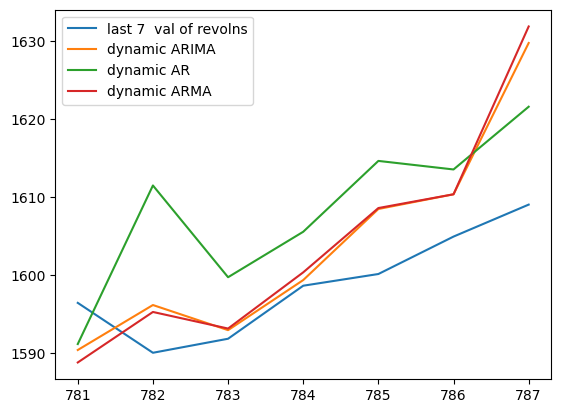

In [247]:
plt.plot(nonrev_x_test, nonrev_y_test, label='last 7  val of revolns')
# plt.plot(rev_x_axis_values[450:],rev_train[450:], label='revolns[450:]')
plt.plot(nonrev_x_test, dynamic_arima_nonrev_prediction, label='dynamic ARIMA')
plt.plot(nonrev_x_test, dynamic_ar_nonrev_prediction, label='dynamic AR')
plt.plot(nonrev_x_test, dynamic_arma_nonrev_prediction, label='dynamic ARMA')
plt.legend()